In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import os
import copy

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [10]:
data_transforms = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=mean, std=std)
                                 ]),
    'val': transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=mean, std=std)
                               ])
}

In [11]:
data_dir = './hymenoptera_data'
sets = ['train', 'val']
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


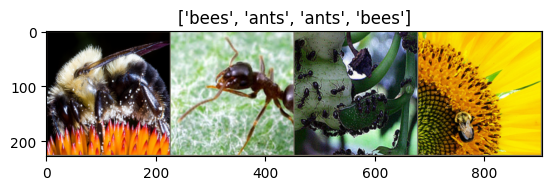

In [12]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch:{epoch}/{num_epochs-1}')
        print('-' * 10)
        
        # Each Epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0
            
            # Iterate over Data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Forward Pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                # Stats for Nerds
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep Copy the Model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60} minutes, {time_elapsed % 60} seconds')
    print(f'Best val acc: {best_acc}')

    # Load Best Model Weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features # fc = fully connected, in_features = input features

model.fc = nn.Linear(num_features, 2) # outputs = 2, input = num_features
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001) # SGD = Stochastic Gradient Descent

# Scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Every 7 epochs, LR is multiplied by Gamma (0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=20)
# What is actually happening:
# for epoch in range(100):
#     train() # optimizer.step()
#     evaluate()
#     scheduler.step()

In [14]:
# Freeze all the layers in the beginning and only train the very last layer
# This is faster
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_features = model.fc.in_features # fc = fully connected, in_features = input features
model.fc = nn.Linear(num_features, 2) # outputs = 2, input = num_features
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001) # SGD = Stochastic Gradient Descent

# Scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Every 7 epochs, LR is multiplied by Gamma (0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=20)

C:\Users\SIDDHANT\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\SIDDHANT\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\SIDDHANT/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:59<00:00, 783kB/s] 


Epoch:0/19
----------
train Loss: 0.6657 Acc: 0.5902
val Loss: 0.5954 Acc: 0.6209

Epoch:1/19
----------
train Loss: 0.5684 Acc: 0.7295
val Loss: 0.4365 Acc: 0.8562

Epoch:2/19
----------
train Loss: 0.5437 Acc: 0.7377
val Loss: 0.4005 Acc: 0.8562

Epoch:3/19
----------
train Loss: 0.4879 Acc: 0.7582
val Loss: 0.3166 Acc: 0.9216

Epoch:4/19
----------
train Loss: 0.4858 Acc: 0.7787
val Loss: 0.2986 Acc: 0.9412

Epoch:5/19
----------
train Loss: 0.4870 Acc: 0.7582
val Loss: 0.2722 Acc: 0.9346

Epoch:6/19
----------
train Loss: 0.4724 Acc: 0.8074
val Loss: 0.2582 Acc: 0.9281

Epoch:7/19
----------
train Loss: 0.4385 Acc: 0.8197
val Loss: 0.2532 Acc: 0.9281

Epoch:8/19
----------
train Loss: 0.4010 Acc: 0.8648
val Loss: 0.2547 Acc: 0.9346

Epoch:9/19
----------
train Loss: 0.4538 Acc: 0.7869
val Loss: 0.2534 Acc: 0.9346

Epoch:10/19
----------
train Loss: 0.4144 Acc: 0.8443
val Loss: 0.2587 Acc: 0.9281

Epoch:11/19
----------
train Loss: 0.3930 Acc: 0.8525
val Loss: 0.2470 Acc: 0.9346

Ep